In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
#change the path accordngly to csv file. This csv file only has 200 data points
data = pd.read_csv("Mall_Customers.csv")

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [4]:
data.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [5]:
X = data[['Age', 'Annual Income (k$)','Spending Score (1-100)']]

In [6]:
# 80% data for training (160 first rows)
# 20% for testing (40 last rows)
train_set = X.iloc[:160,:]
test = X.iloc[160:,:]

In [7]:
from sklearn.cluster import DBSCAN

# min_samples: number of minpoints
# eps is the radius of neighbourhood for any point
dbscan = DBSCAN(eps=12.5, min_samples=4, metric='euclidean')
dbscan.fit(train_set)

DBSCAN(eps=12.5, min_samples=4)

In [20]:
dbscan.components_[0:10]

array([[21, 15, 81],
       [23, 16, 77],
       [31, 17, 40],
       [22, 17, 76],
       [30, 19, 72],
       [24, 20, 77],
       [22, 20, 79],
       [35, 21, 35],
       [20, 21, 66],
       [35, 24, 35]])

In [9]:
x_train = train_set.copy()
# dbscan.labels_ contains the labels assigned to samples
x_train['cluster'] = dbscan.labels_
x_train.head()

,Age,Annual Income (k$),Spending Score (1-100),cluster
0,19,15,39,0
1,21,15,81,0
2,20,16,6,-1
3,23,16,77,0
4,31,17,40,0


In [11]:
# number of clusters and number of samples belonging to each cluster

x_train['cluster'].value_counts()

 0    112
 2     19
-1     12
 3      9
 1      8
Name: cluster, dtype: int64

In [12]:
# noise points will belonging to -1
noise = x_train[x_train['cluster'] == -1]

[None, None, None, None, None, None, None, None, None, None]

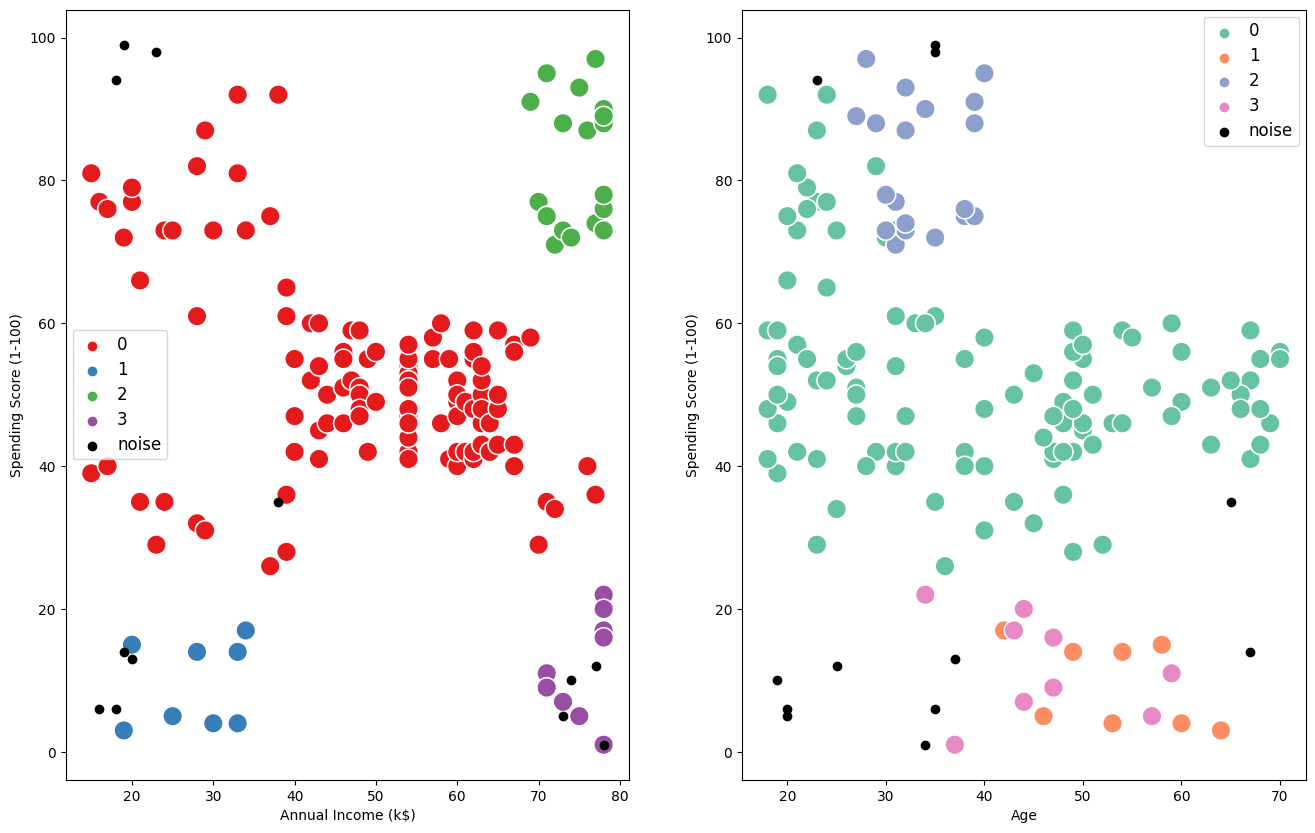

In [18]:
fig, (ax) = plt.subplots(1,2,figsize=(16,10))

sns.scatterplot(x ='Annual Income (k$)',
                y ='Spending Score (1-100)',
                data=x_train[x_train['cluster'] != -1],
                hue='cluster',
                legend='full',
                palette='Set1',
                ax=ax[0],
                s=200)

sns.scatterplot(x='Age',
                y='Spending Score (1-100)',
                data=x_train[x_train['cluster'] != -1],
                hue='cluster',
                palette='Set2',
                ax=ax[1],
                legend='full',
                s=200)

ax[0].scatter(x='Annual Income (k$)',
              y='Spending Score (1-100)',
              data=noise,
              label='noise',
              c='black')

ax[1].scatter(x='Age',
              y='Spending Score (1-100)',
              data=noise,
              label='noise',
              c='black')

ax[0].legend()
ax[1].legend()

plt.setp(ax[0].get_legend().get_texts(), fontsize = '12')
plt.setp(ax[1].get_legend().get_texts(), fontsize = '12')

In [22]:
# DBSCAN does not have the prediction method to predict clusters for new data points and test samples
# It is necessary to create your own prediction function

from sklearn.metrics import pairwise_distances

import numpy as np
def predict_cluster(dbscan, X_new, metric):
    """ Predicts the cluster label for new samples using a trained DBSCAN model.
    Parameters:
    dbscan: trained DBSCAN model
    X_new: array of new samples,
    metric: the distance criteria used same as used for training the DBSCAN
    shape (n_samples, n_features)
    Returns: array of predicted cluster labels, shape (n_samples,)
    """
    # Calculate pairwise distances between new samples and all samples in the training set
    distances = pairwise_distances(X_new, dbscan.components_, metric=metric)
    # Find the index of the closest sample within eps distance  (minimum euclidian distance found)
    closest_sample_indices = np.argmin(distances, axis=1)
    # Get the cluster labels of the closest samples by passing the index
    closest_sample_labels = dbscan.labels_[closest_sample_indices]
    return closest_sample_labels

In [52]:
test_set = test.copy()

# You can use this function to predict the cluster label of new samples
test_set['cluster'] = predict_cluster(dbscan, test, 'euclidean')
test_set['cluster'].value_counts()

2    19
0    17
3     4
Name: cluster, dtype: int64

In [50]:
# exemple of how the distances are calculated using the euclian distance by hand

import math
# new data: [56, 79, 35] (to predict the cluster)
# old data: [21, 15, 81] (cluster is known)
# the euclidian distance between old and new data: √[(x2 – x1)2 + (y2 – y1)2]
math.sqrt((56-21)**2 + (79-15)**2 + (35-81)**2)

86.23804264940155